In [1]:
from pathlib import Path
from fastai.vision.all import *

# Train the model using resnet

In [2]:
img_dir = Path('../data/processed/voronoi')

dls = ImageDataLoaders.from_folder(
    img_dir, 
    train='train',
    valid=None,
    valid_pct=0.2,
    bs=16,
    shuffle_train=True
)

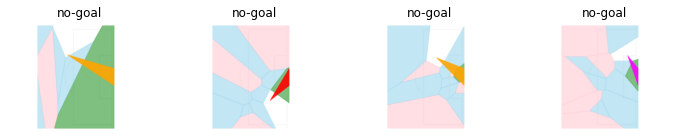

In [3]:
dls.show_batch(nrows=1, ncols=4)

In [4]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=7.585775847473997e-07)

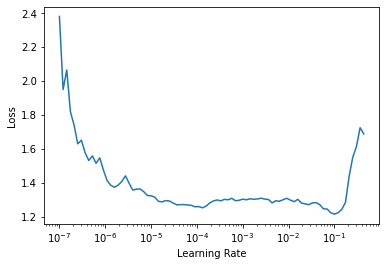

In [5]:
learn.lr_find()

In [6]:
learn.fit_one_cycle(3, slice(1e-7, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.623324,0.495372,0.168687,0.831313,00:17
1,0.434680,0.370356,0.117172,0.882828,00:17
2,0.298311,0.315702,0.101010,0.898990,00:17


In [7]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

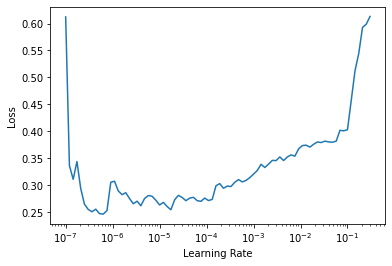

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.271461,0.323779,0.110101,0.889899,00:20
1,0.237297,0.320406,0.117172,0.882828,00:20
2,0.186299,0.332446,0.113131,0.886869,00:20


# Review the model

Make some predictions on the test-data.

First, let's go through predicting a single image...

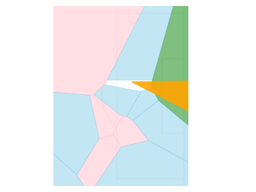

In [10]:
import PIL

# Load an image from the test data
example_img_path = (img_dir/'test'/'goal').ls()[0]
example_img = PILImage.create(example_img_path)

display(example_img.to_thumb(256, 256))

In [11]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

xG: 0.6529016494750977


Load all test data

In [12]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [13]:
import fastprogress
fastprogress.fastprogress.NO_BAR = True


def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = (img_dir/'test'/'goal').ls() + (img_dir/'test'/'no-goal').ls()
shots_predicted = [process_test_shot(s) for s in test_shots]

In [14]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

,path,id,is_goal,xg,sb_xg,diff
0,../data/processed/voronoi/test/goal/c8be266f-0b0f-4bdc-9dae-132c8fe4fb7f.png,c8be266f-0b0f-4bdc-9dae-132c8fe4fb7f,True,0.652902,0.307130,0.345771
1,../data/processed/voronoi/test/goal/d8769961-69e4-43ce-a081-aa41be7136d6.png,d8769961-69e4-43ce-a081-aa41be7136d6,True,0.200526,0.296505,0.095979
2,../data/processed/voronoi/test/goal/de115b57-dc76-4489-ad4b-df20717e48ae.png,de115b57-dc76-4489-ad4b-df20717e48ae,True,0.841747,0.201109,0.640638
3,../data/processed/voronoi/test/goal/2bf35d45-298f-4f3b-a1bb-df95b7082500.png,2bf35d45-298f-4f3b-a1bb-df95b7082500,True,0.768317,0.395538,0.372779
4,../data/processed/voronoi/test/goal/e98c4c91-df68-4973-a6bc-247e6cfb318e.png,e98c4c91-df68-4973-a6bc-247e6cfb318e,True,0.649535,0.390140,0.259394
...,...,...,...,...,...,...
955,../data/processed/voronoi/test/no-goal/b463b943-b669-4409-aa62-4a020fe75d96.png,b463b943-b669-4409-aa62-4a020fe75d96,False,0.118558,0.032635,0.085923
956,../data/processed/voronoi/test/no-goal/dc52c3e6-2fc2-490c-9d9f-dc7ddff1ca54.png,dc52c3e6-2fc2-490c-9d9f-dc7ddff1ca54,False,0.073645,0.067277,0.006368
957,../data/processed/voronoi/test/no-goal/bd7c3c24-a910-4e66-b95e-bf6b7f3792e1.png,bd7c3c24-a910-4e66-b95e-bf6b7f3792e1,False,0.106309,0.276825,0.170516
958,../data/processed/voronoi/test/no-goal/36c2b9fb-cea9-4985-aac9-bb582d60e516.png,36c2b9fb-cea9-4985-aac9-bb582d60e516,False,0.044770,0.056581,0.011811


Compare to SB xG

In [15]:
# Compare overall error rate between SB and image xG
import numpy as np


def mse(pred, obs):
    return np.mean((obs - pred)**2)


def rmse(pred, obs):
    return np.sqrt(mse(pred, obs))


print(rmse(predictions['is_goal'].mean(), predictions['is_goal']))
print(rmse(predictions['sb_xg'], predictions['is_goal']))
print(rmse(predictions['xg'], predictions['is_goal']))

0.3041220715025465
0.2641333269669333
0.1984801283222346


ID: 2092971a-13bc-4609-8885-c5c88c36b15a
Im-xG: 0.08
SB-xG: 0.82
Goal: True
Diff:  0.74


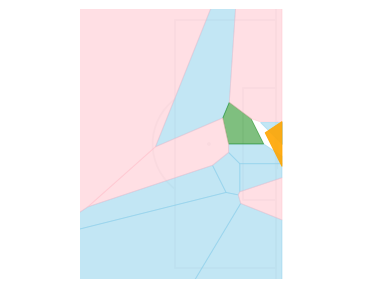

ID: 711160a4-3b4e-4716-84d7-8ae9dd839516
Im-xG: 0.78
SB-xG: 0.06
Goal: True
Diff:  0.71


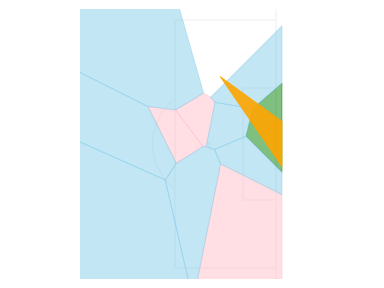

ID: 58ac5898-041d-41e7-9384-23661d0deb0a
Im-xG: 0.75
SB-xG: 0.05
Goal: True
Diff:  0.70


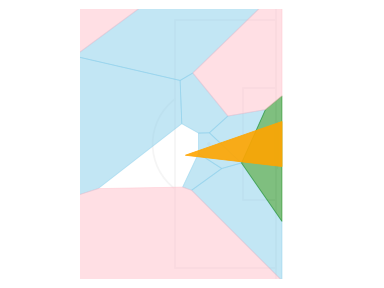

ID: a084c421-f15e-4784-8977-107137728faf
Im-xG: 0.13
SB-xG: 0.81
Goal: False
Diff:  0.68


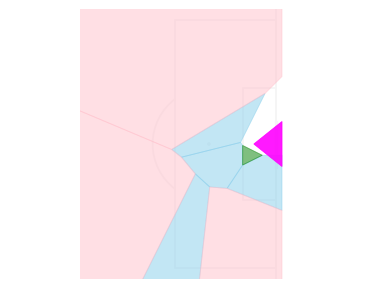

ID: 2f067263-04de-474b-814f-f6a55d7d3115
Im-xG: 0.73
SB-xG: 0.05
Goal: True
Diff:  0.67


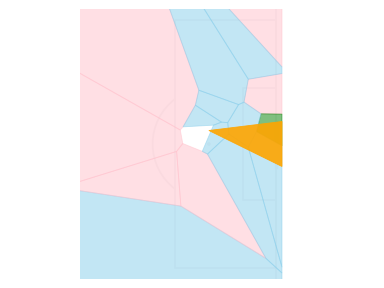

ID: c91466fd-c717-4166-81fd-6c16fd98ba00
Im-xG: 0.71
SB-xG: 0.06
Goal: True
Diff:  0.65


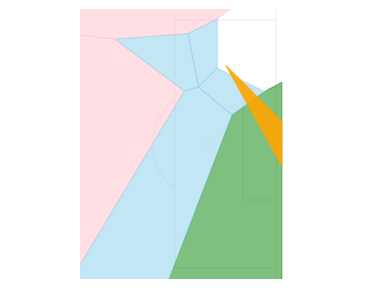

ID: 564a458f-3a60-4b92-b432-ddf04bbfc9e3
Im-xG: 0.67
SB-xG: 0.03
Goal: True
Diff:  0.64


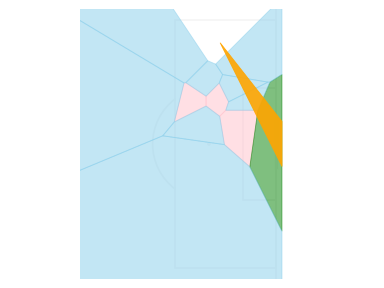

ID: de115b57-dc76-4489-ad4b-df20717e48ae
Im-xG: 0.84
SB-xG: 0.20
Goal: True
Diff:  0.64


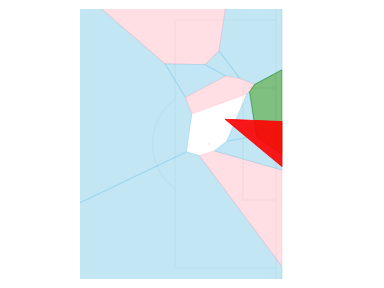

ID: ef28ceeb-deb0-44cf-9a54-94b4aa671dbf
Im-xG: 0.89
SB-xG: 0.25
Goal: True
Diff:  0.64


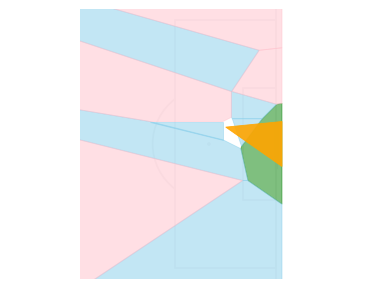

ID: 0b7a147b-8b0c-410b-bb55-abd3d1600da0
Im-xG: 0.68
SB-xG: 0.06
Goal: True
Diff:  0.63


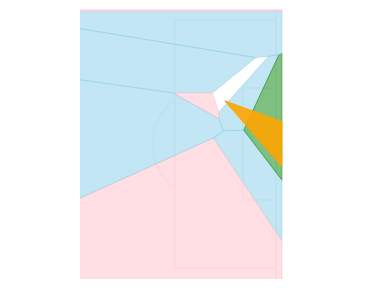

In [16]:
for _, p in predictions.sort_values(by='diff', ascending=False).head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

ID: de115b57-dc76-4489-ad4b-df20717e48ae
Im-xG: 0.84
SB-xG: 0.20
Goal: True
Diff:  0.64


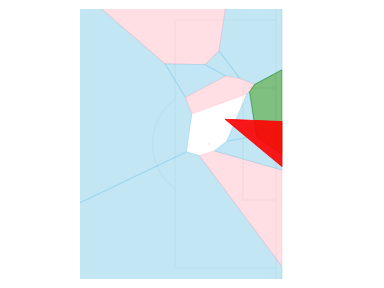

ID: 3b7b429c-3cea-4342-9da3-3021f129f302
Im-xG: 0.59
SB-xG: 0.20
Goal: True
Diff:  0.40


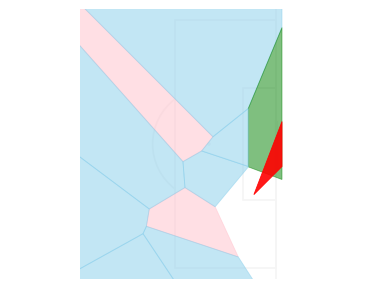

ID: 4710b288-763b-4bee-8a8d-3b18ad9a5bed
Im-xG: 0.75
SB-xG: 0.18
Goal: True
Diff:  0.56


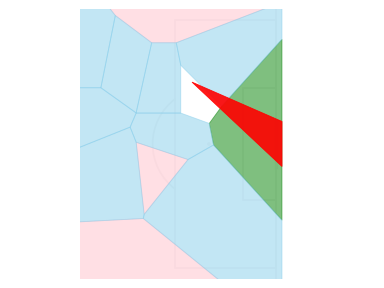

ID: 75783195-4af5-4306-97e2-44fe8ee32db1
Im-xG: 0.58
SB-xG: 0.19
Goal: True
Diff:  0.40


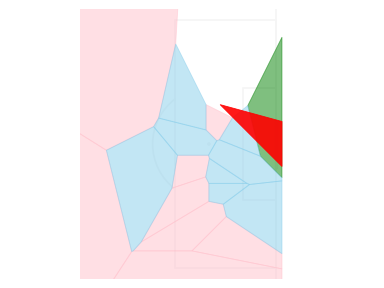

ID: d7eefde4-6f09-40bf-a322-a9fbfb6d4e5f
Im-xG: 0.53
SB-xG: 0.19
Goal: True
Diff:  0.35


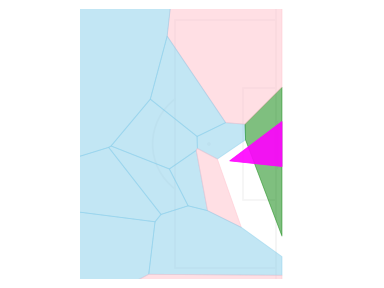

ID: e7ff65f9-6f3d-47da-a5a5-447d487e6179
Im-xG: 0.53
SB-xG: 0.19
Goal: True
Diff:  0.34


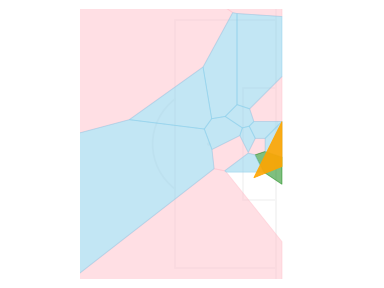

ID: c5976e08-e311-4860-9e56-0f53ffe6a7b5
Im-xG: 0.46
SB-xG: 0.19
Goal: True
Diff:  0.27


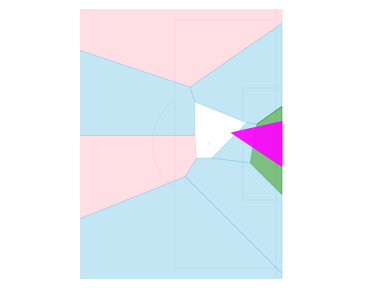

ID: 633d241a-9d30-4da1-ba6b-637bd35270f7
Im-xG: 0.02
SB-xG: 0.21
Goal: False
Diff:  0.18


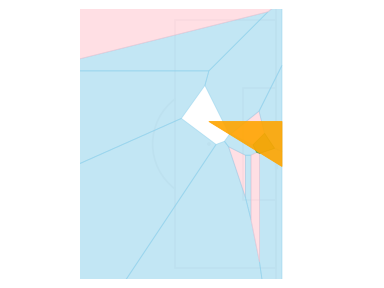

ID: 724cc6ed-584f-48a2-a915-704673c9c4e2
Im-xG: 0.18
SB-xG: 0.21
Goal: False
Diff:  0.03


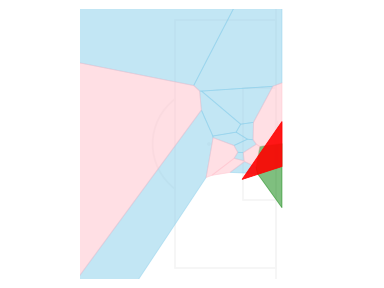

ID: c1db5e56-b29c-4869-955e-82124106d63d
Im-xG: 0.07
SB-xG: 0.19
Goal: False
Diff:  0.12


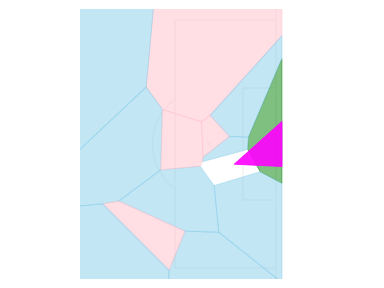

ID: c87b7e74-3432-4f23-97a6-aab2d2f849d5
Im-xG: 0.04
SB-xG: 0.19
Goal: False
Diff:  0.15


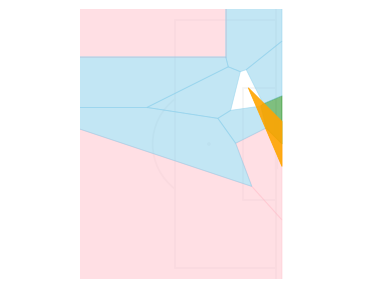

ID: 2d72fb1c-e6e9-4f0b-ba55-829132da4cd5
Im-xG: 0.07
SB-xG: 0.21
Goal: False
Diff:  0.14


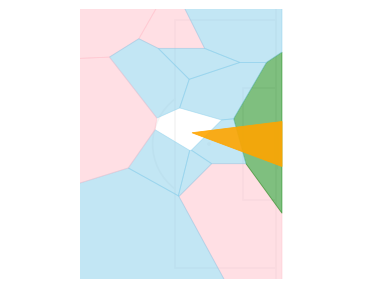

ID: 64fb106d-153b-4919-adad-ee604dbad2f3
Im-xG: 0.20
SB-xG: 0.20
Goal: False
Diff:  0.00


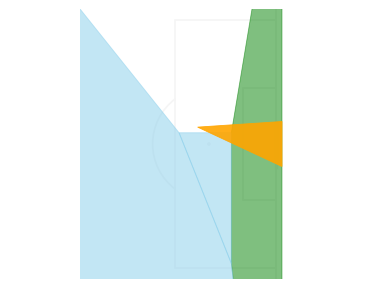

ID: 3cf4dc65-3f26-4a5c-9fbc-a9fa3a6c9d2f
Im-xG: 0.05
SB-xG: 0.20
Goal: False
Diff:  0.16


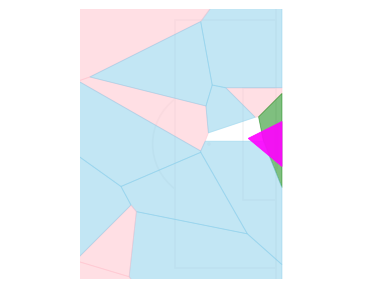

ID: 4a16a20d-9544-4666-b44b-2853bbeb7cbf
Im-xG: 0.29
SB-xG: 0.20
Goal: False
Diff:  0.09


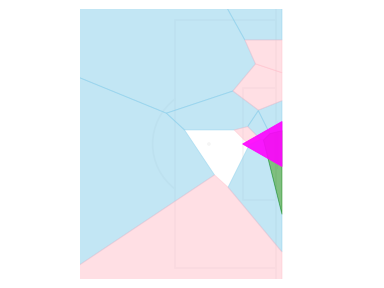

ID: bc0c4bf4-0e01-4349-8622-a4a9ccbe4ef9
Im-xG: 0.13
SB-xG: 0.19
Goal: False
Diff:  0.06


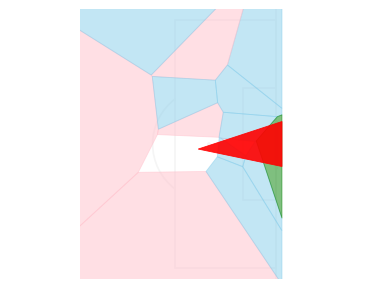

ID: c99b57d6-72cb-4100-a60a-1e9fb9b7433c
Im-xG: 0.09
SB-xG: 0.20
Goal: False
Diff:  0.11


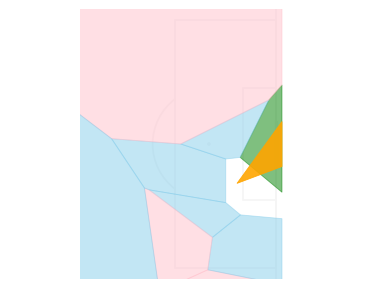

ID: 439ac9ec-1fcb-4a5e-87b6-e0777363eb28
Im-xG: 0.12
SB-xG: 0.20
Goal: False
Diff:  0.08


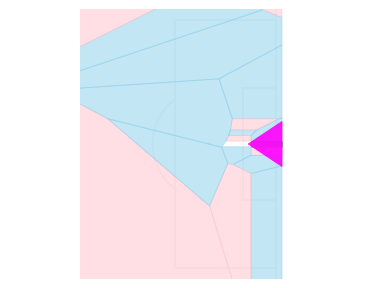

ID: ca111176-6203-47af-a588-a0318f5ae5e5
Im-xG: 0.07
SB-xG: 0.18
Goal: False
Diff:  0.12


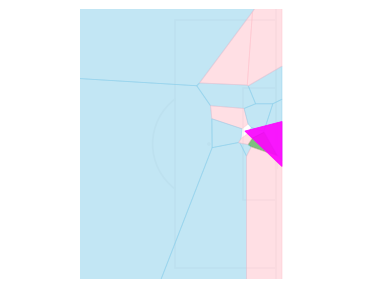

ID: 52020e34-49e7-499b-aace-e1b16331bfa2
Im-xG: 0.02
SB-xG: 0.22
Goal: False
Diff:  0.19


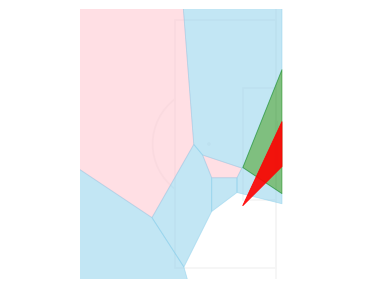

ID: bed1e4ef-2191-4700-adca-c32ff31f461c
Im-xG: 0.11
SB-xG: 0.22
Goal: False
Diff:  0.11


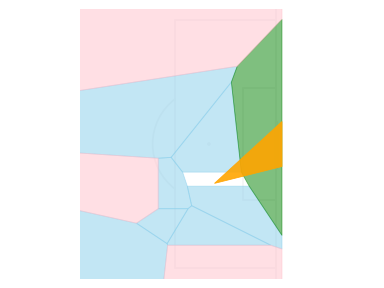

ID: 1fd4863b-127d-49ac-b284-5b0db1cc260a
Im-xG: 0.17
SB-xG: 0.21
Goal: False
Diff:  0.03


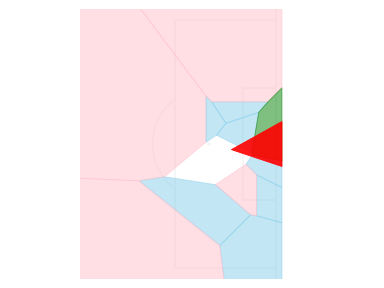

ID: f0447d97-92f4-4d8c-9db7-3956eabd64ef
Im-xG: 0.16
SB-xG: 0.22
Goal: False
Diff:  0.06


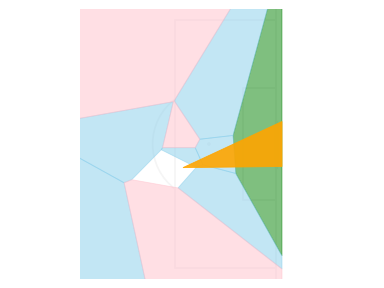

ID: 9ca96dab-7d71-4d9e-a6fa-16341869e3da
Im-xG: 0.19
SB-xG: 0.19
Goal: False
Diff:  0.00


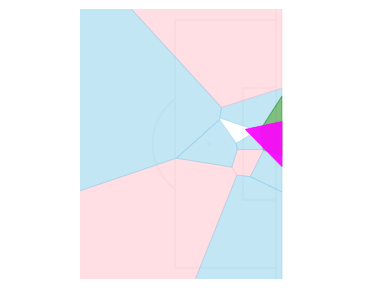

ID: e91c97fa-b058-4348-947f-4f81cf051b7f
Im-xG: 0.55
SB-xG: 0.20
Goal: False
Diff:  0.35


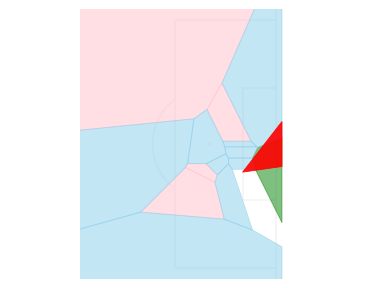

In [17]:
for _, p in predictions.loc[lambda df: (df['sb_xg'] < 0.22) & (df['sb_xg'] > 0.18)].iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

<AxesSubplot:xlabel='xg', ylabel='sb_xg'>

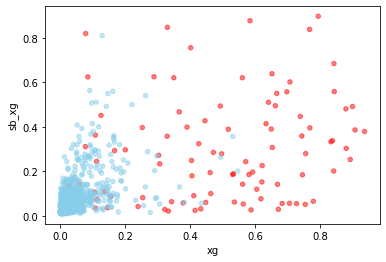

In [18]:
predictions.assign(
    is_goal=lambda df: df['is_goal'].map({False:'skyblue', True:'red'})
).plot(
    x='xg', y='sb_xg', c='is_goal', kind='scatter', alpha=0.5
)

ID: e91c97fa-b058-4348-947f-4f81cf051b7f
Im-xG: 0.55
SB-xG: 0.20
Goal: False
Diff:  0.35


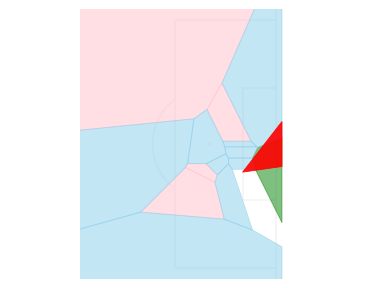

ID: 776269a7-8205-4676-92eb-0ecdc851cd9c
Im-xG: 0.53
SB-xG: 0.36
Goal: False
Diff:  0.17


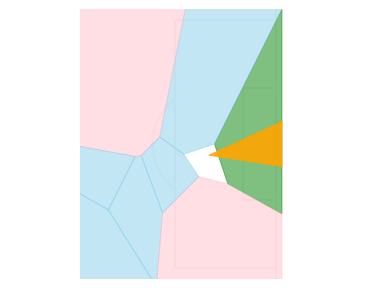

ID: a3e78778-883f-4309-b1b2-40fab9617e97
Im-xG: 0.49
SB-xG: 0.26
Goal: False
Diff:  0.23


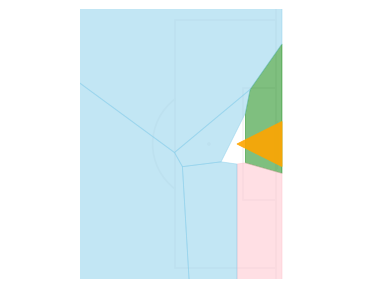

ID: 0ecd978f-b3a4-4d2e-a409-90c189ccfe75
Im-xG: 0.44
SB-xG: 0.06
Goal: False
Diff:  0.38


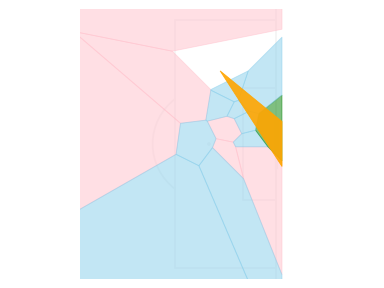

ID: e47550fa-ab79-4d4e-bb67-9a14b138c9d0
Im-xG: 0.38
SB-xG: 0.06
Goal: False
Diff:  0.32


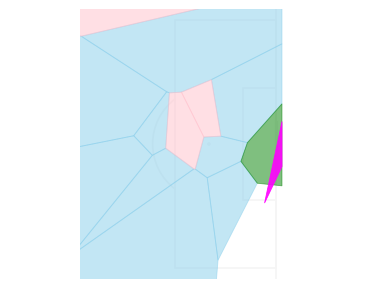

ID: fb666a28-df6e-452e-9cd1-1f299a1857c1
Im-xG: 0.37
SB-xG: 0.13
Goal: False
Diff:  0.24


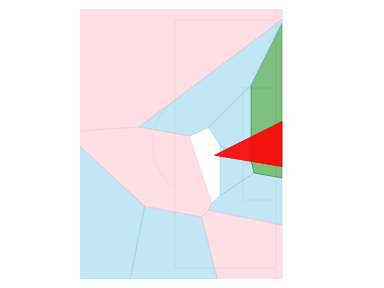

ID: 940d5a14-6266-4f37-ac12-c96727dafd44
Im-xG: 0.31
SB-xG: 0.05
Goal: False
Diff:  0.25


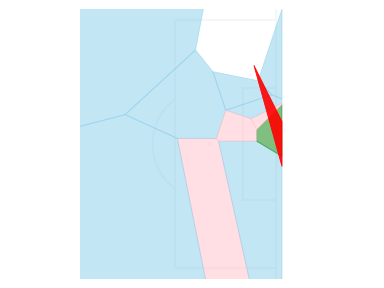

ID: f21b0234-c04d-43af-9ade-58809e70b546
Im-xG: 0.30
SB-xG: 0.27
Goal: False
Diff:  0.03


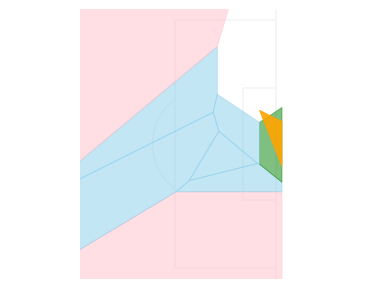

ID: 4f0c97f8-2b95-4276-b05c-04f2d311fbd3
Im-xG: 0.30
SB-xG: 0.08
Goal: False
Diff:  0.22


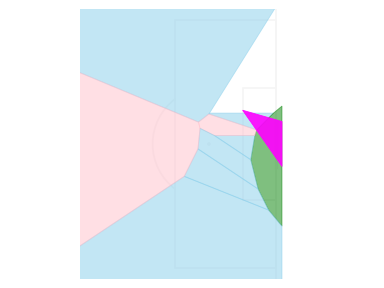

ID: d1b7b5de-5cf7-4935-a4f3-c9ac0ee984f3
Im-xG: 0.29
SB-xG: 0.08
Goal: False
Diff:  0.22


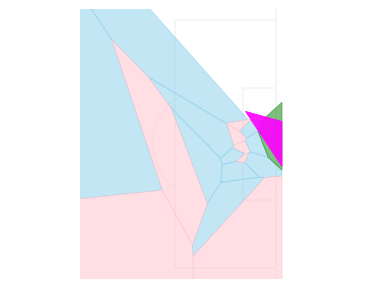

ID: 4a16a20d-9544-4666-b44b-2853bbeb7cbf
Im-xG: 0.29
SB-xG: 0.20
Goal: False
Diff:  0.09


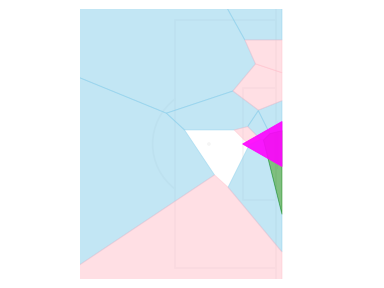

ID: 5ce50922-235b-4d69-9ac4-8f64d6200c44
Im-xG: 0.28
SB-xG: 0.01
Goal: False
Diff:  0.26


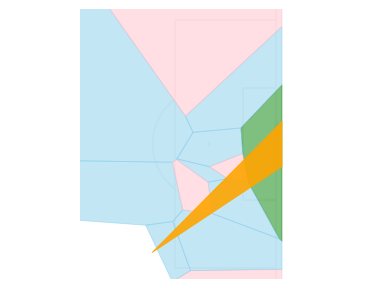

ID: e72b8259-c94d-4e0c-a2e9-360eb11fb9a3
Im-xG: 0.27
SB-xG: 0.29
Goal: False
Diff:  0.02


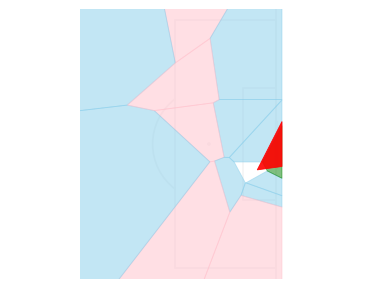

ID: 2119b696-7cee-4cc3-98e5-e272b3b96c30
Im-xG: 0.26
SB-xG: 0.54
Goal: False
Diff:  0.28


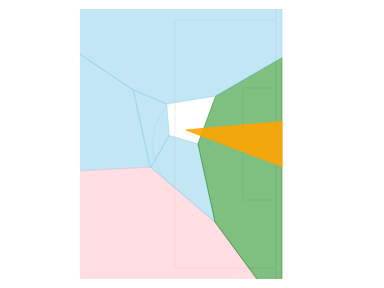

ID: 63240ab3-e9c4-43ff-9a8c-ef69fc80d7bf
Im-xG: 0.26
SB-xG: 0.13
Goal: False
Diff:  0.13


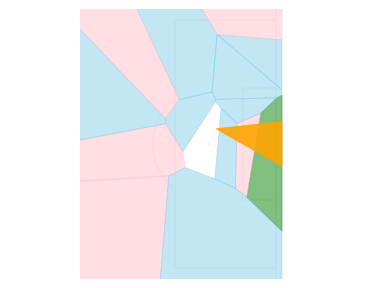

In [19]:
for _, p in predictions.loc[lambda df: ~df['is_goal']].sort_values(by='xg', ascending=False).head(15).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'ID: {p["id"]}')
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Goal: {p["is_goal"]}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

<AxesSubplot:xlabel='xg', ylabel='is_goal'>

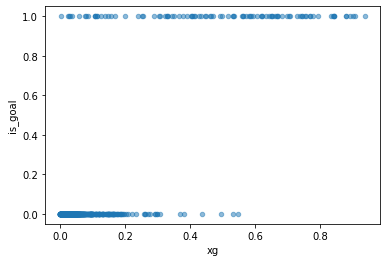

In [20]:
predictions.assign(is_goal=lambda df: df['is_goal'].astype(int)).plot(x='xg', y='is_goal', kind='scatter', alpha=0.5)